In [125]:
import time
start = time.time()

In [126]:
#IMPORTS
from datetime import datetime
from pyspark.ml.fpm import PrefixSpan
from pyspark.sql import Row
import pyspark.sql.functions as F
from math import sin, cos, sqrt, atan2, radians 
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import operator

In [ ]:
#parameters
support=0.05
support_str = "005" #used for paths
interval=15 #time window
maxDelta=3 #how many delta
th=1 #distance
window_size=4 #window size

In [127]:
#FILES
inputPath  = "file:///home/bigdata-01QYD/s270240/bike_sharing/filtered_status.csv"
STATION_PATH="file:///home/bigdata-01QYD/s270240/bike_sharing/station.csv"
#save file of first filter
output_file=f'./Results_extraction/AllStates/AllStates_{interval}_{th*1000}_{support_str}({window_size}-{maxDelta})/results_{th*1000}_{support_str}_ordered_by_confidence.txt'
# output_file2='results_1000_0_QuasiVuota_Vuota_ordered_by_confidence.txt'
output_file3=f'./Results_extraction/AllStates/AllStates_{interval}_{th*1000}_{support_str}({window_size}-{maxDelta})/results_{th*1000}_{support_str}_diff_delta_ordered_by_confidence.txt'
output_file4=f'./Results_extraction/AllStates/AllStates_{interval}_{th*1000}_{support_str}({window_size}-{maxDelta})/results_{th*1000}_{support_str}_ordered_by_support.txt'
# output_file5='results_1000_0_QuasiVuota_Vuota_ordered_by_support.txt'
output_file6=f'./Results_extraction/AllStates/AllStates_{interval}_{th*1000}_{support_str}({window_size}-{maxDelta})/results_{th*1000}_{support_str}_diff_delta_ordered_by_support.txt'
img_support=f'{window_size}-{maxDelta}-{th*1000}-{support_str}.jpg'

In [128]:
inputDF = spark.read.format("csv")\
.option("delimiter", ",")\
.option("header", True)\
.option("inferSchema", True).load(inputPath)

In [129]:
inputDF=inputDF.filter("bikes_available is not null")

In [131]:
#filter for these fields
filteredDF = inputDF.filter("docks_available<>0 OR bikes_available<>0")

In [132]:
#determine if the station is empty, almost empty, full or almost full
def stateFunction(docks_available,bikes_available):
    if bikes_available==0: #empty
        return 1
    elif (bikes_available==1 or bikes_available==2): #almost empty
        return 0
    elif docks_available ==0: #full
        return 2
    elif (docks_available==1 or docks_available==2): #almost full
        return 3    
    else:
        return 4

In [133]:
spark.udf.register("state", stateFunction)

<function __main__.stateFunction(docks_available, bikes_available)>

In [134]:
def getInt(station):
    return (station)

In [135]:
spark.udf.register("intValue", getInt)

<function __main__.getInt(station)>

In [136]:
getStatusDF = filteredDF.selectExpr("station_id","time", "state(docks_available,bikes_available) as status")

In [137]:
#getStatusDF.show(100,False)

In [138]:
#filter only empty or almost empty stations
allStates=getStatusDF.filter("status==1  or status==0 or status==2  or status==3")

In [139]:
allStates_count = allStates.count()

In [140]:
allStates_count/getStatusDF.count()*100

7.869858960895086

In [141]:
allStates.describe().show()

+-------+-----------------+------------------+
|summary|       station_id|            status|
+-------+-----------------+------------------+
|  count|          5664560|           5664560|
|   mean|49.71981707317073| 1.282092872173655|
| stddev| 21.6347726260795|1.3787953571083422|
|    min|                2|                 0|
|    max|               84|                 3|
+-------+-----------------+------------------+



In [142]:
#create a view
allStates.createOrReplaceTempView("readings")

In [143]:
#select station, year, month, day, hour, minute, status ordered by time
ss=spark.sql("""SELECT  station_id , YEAR(time) as year, MONTH(time) as month, DAY(time) as day, HOUR(time)as hour, MINUTE(time) as minute, status
FROM readings
GROUP BY station_id, year, month, day,hour,minute, status
ORDER BY  station_id,year, month,day, hour,minute
""")

In [144]:
#create rdd and group into interval
my_rdd=ss.rdd.map(tuple)
rdd=my_rdd.map(lambda line: (line[0],line[1],line[2], line[3], line[4], int(line[5]/interval), line[6])).distinct()
# rdd.collect()

#  [(32, 2014, 8, 19, 19, 1, '0'),
#  (32, 2014, 8, 20, 17, 0, '1'),
#  (32, 2014, 9, 4, 19, 1, '0'),
#  (32, 2014, 9, 5, 8, 1, '0'),
#  (32, 2014, 9, 5, 16, 1, '0'),
#  (32, 2014, 10, 16, 7, 0, '0'),, ... ]

In [145]:
#get distinct stations to calculate distances
id_stations=rdd.map(lambda line: line[0]).distinct()

In [146]:
tot_id_stations=id_stations.collect()

In [147]:
#list of all stations
#tot_id_stations

In [148]:
#obtain timestamp and info
def getMap(line):
    id_station=str(line[0])
    year=int(line[1])
    month=int(line[2])
    day=int(line[3])
    hour=int(line[4])
    minute=int(line[5])   
    timestamp= datetime(year,month, day, hour, minute)  
    status=int(line[6])
    if status==0:
        status='QuasiVuota'
    elif status==1:
        status='Vuota'
    elif status==2:
        status='Piena'
    elif status==3:
        status='QuasiPiena'
    info=id_station.split('.')[0]+'_'+status
    return ( (timestamp,info))

In [149]:
get_map=rdd.map(getMap)
# get_map.collect()

# [(datetime.datetime(2014, 4, 18, 14, 1), '10_QuasiVuota'),
#  (datetime.datetime(2014, 6, 12, 14, 1), '10_Vuota'),
#  (datetime.datetime(2014, 7, 30, 13, 1), '10_Vuota'),
#  (datetime.datetime(2015, 8, 5, 16, 0), '54_QuasiPiena'),
#  (datetime.datetime(2013, 9, 9, 10, 1), '55_QuasiVuota'),
#  (datetime.datetime(2013, 10, 3, 5, 0), '55_Piena'), ...]

In [150]:
#for each timestamp obtain info
reduceK=get_map.reduceByKey(lambda l1,l2 :(l1+','+l2)).sortByKey()
# reduceK.collect()

# [(datetime.datetime(2013, 8, 29, 10, 0),
#   '59_QuasiVuota,67_QuasiVuota,70_QuasiVuota,6_QuasiVuota,16_QuasiVuota,67_Vuota,4_Vuota,2_QuasiVuota,13_Vuota,70_Vuota,7_Vuota'),
#  (datetime.datetime(2013, 8, 29, 10, 1),
#   '16_QuasiVuota,59_QuasiVuota,2_QuasiVuota,67_Vuota,67_QuasiVuota,4_Vuota,64_QuasiPiena,60_QuasiPiena,70_QuasiVuota,69_QuasiVuota,45_Piena,7_Vuota,13_QuasiVuota,7_QuasiVuota,73_QuasiVuota,13_Vuota,45_QuasiPiena'),
#  (datetime.datetime(2013, 8, 29, 11, 0),
#   '64_QuasiPiena,64_Piena,67_QuasiVuota,45_Piena,69_QuasiVuota,2_QuasiVuota,73_QuasiVuota,4_Vuota,67_Vuota,4_QuasiVuota,45_QuasiPiena,70_QuasiVuota,16_QuasiVuota'),
#  (datetime.datetime(2013, 8, 29, 11, 1),
#   '69_QuasiVuota,67_QuasiVuota,73_QuasiVuota,64_QuasiPiena,2_QuasiVuota,16_QuasiVuota,35_QuasiPiena'),
#  (datetime.datetime(2013, 8, 29, 12, 0), ...]

In [151]:
my_df=reduceK.toDF()
#my_df.collect()

In [152]:
my_df.createOrReplaceTempView("view")

In [153]:
s2=spark.sql("""SELECT ROW_NUMBER() OVER(ORDER BY _1,_2) as id ,_1, _2
FROM view """)

In [154]:
#identifier of the timestamp, info
rdd_scheme=s2.rdd.map(tuple).map(lambda line: (line[0], line[2]))
# rdd_scheme.collect()

# [(1, '59_QuasiVuota,67_QuasiVuota,70_QuasiVuota,6_QuasiVuota,16_QuasiVuota,67_Vuota,4_Vuota,2_QuasiVuota,13_Vuota,70_Vuota,7_Vuota'),
#  (2, '16_QuasiVuota,59_QuasiVuota,2_QuasiVuota,67_Vuota,67_QuasiVuota,4_Vuota,64_QuasiPiena,60_QuasiPiena,70_QuasiVuota,69_QuasiVuota,45_Piena,7_Vuota,13_QuasiVuota,7_QuasiVuota,73_QuasiVuota,13_Vuota,45_QuasiPiena'),
#  (3, '64_QuasiPiena,64_Piena,67_QuasiVuota,45_Piena,69_QuasiVuota,2_QuasiVuota,73_QuasiVuota,4_Vuota,67_Vuota,4_QuasiVuota,45_QuasiPiena,70_QuasiVuota,16_QuasiVuota'),
#  (4, '69_QuasiVuota,67_QuasiVuota,73_QuasiVuota,64_QuasiPiena,2_QuasiVuota,16_QuasiVuota,35_QuasiPiena'),
#  (5, '16_QuasiVuota,69_QuasiVuota,73_QuasiVuota,69_Vuota,2_QuasiVuota,35_QuasiPiena,64_QuasiPiena,60_QuasiPiena'), ...]

In [155]:
#obtain window, station-status
def giveSplit(line):   
    id_window=( int(line[0] ))
    lista=[]    
    counter=id_window    
    while counter>=1:
        lista.append(('Window '+str(counter),(line[1])))
        counter=counter-1
        if (id_window-counter)==window_size:
            return lista  
    return lista

In [156]:
mapData=rdd_scheme.flatMap(giveSplit)
# mapData.collect()

# [('Window 1',
#   '59_QuasiVuota,67_QuasiVuota,70_QuasiVuota,6_QuasiVuota,16_QuasiVuota,67_Vuota,4_Vuota,2_QuasiVuota,13_Vuota,70_Vuota,7_Vuota'),
#  ('Window 2',
#   '16_QuasiVuota,59_QuasiVuota,2_QuasiVuota,67_Vuota,67_QuasiVuota,4_Vuota,64_QuasiPiena,60_QuasiPiena,70_QuasiVuota,69_QuasiVuota,45_Piena,7_Vuota,13_QuasiVuota,7_QuasiVuota,73_QuasiVuota,13_Vuota,45_QuasiPiena'),
#  ('Window 1',
#   '16_QuasiVuota,59_QuasiVuota,2_QuasiVuota,67_Vuota,67_QuasiVuota,4_Vuota,64_QuasiPiena,60_QuasiPiena,70_QuasiVuota,69_QuasiVuota,45_Piena,7_Vuota,13_QuasiVuota,7_QuasiVuota,73_QuasiVuota,13_Vuota,45_QuasiPiena'),
#  ('Window 3',
#   '64_QuasiPiena,64_Piena,67_QuasiVuota,45_Piena,69_QuasiVuota,2_QuasiVuota,73_QuasiVuota,4_Vuota,67_Vuota,4_QuasiVuota,45_QuasiPiena,70_QuasiVuota,16_QuasiVuota'),
#  ('Window 2',
#   '64_QuasiPiena,64_Piena,67_QuasiVuota,45_Piena,69_QuasiVuota,2_QuasiVuota,73_QuasiVuota,4_Vuota,67_Vuota,4_QuasiVuota,45_QuasiPiena,70_QuasiVuota,16_QuasiVuota'), ...]

In [157]:
# for each window get all info
all_keys=mapData.reduceByKey(lambda l1,l2:(l1+'-'+l2))

In [158]:
# all_keys.collect()

# [('Window 1',
#   '59_QuasiVuota,67_QuasiVuota,70_QuasiVuota,6_QuasiVuota,16_QuasiVuota,67_Vuota,4_Vuota,2_QuasiVuota,13_Vuota,70_Vuota,7_Vuota-16_QuasiVuota,59_QuasiVuota,2_QuasiVuota,67_Vuota,67_QuasiVuota,4_Vuota,64_QuasiPiena,60_QuasiPiena,70_QuasiVuota,69_QuasiVuota,45_Piena,7_Vuota,13_QuasiVuota,7_QuasiVuota,73_QuasiVuota,13_Vuota,45_QuasiPiena-64_QuasiPiena,64_Piena,67_QuasiVuota,45_Piena,69_QuasiVuota,2_QuasiVuota,73_QuasiVuota,4_Vuota,67_Vuota,4_QuasiVuota,45_QuasiPiena,70_QuasiVuota,16_QuasiVuota'),
#  ('Window 2',
#   '16_QuasiVuota,59_QuasiVuota,2_QuasiVuota,67_Vuota,67_QuasiVuota,4_Vuota,64_QuasiPiena,60_QuasiPiena,70_QuasiVuota,69_QuasiVuota,45_Piena,7_Vuota,13_QuasiVuota,7_QuasiVuota,73_QuasiVuota,13_Vuota,45_QuasiPiena-64_QuasiPiena,64_Piena,67_QuasiVuota,45_Piena,69_QuasiVuota,2_QuasiVuota,73_QuasiVuota,4_Vuota,67_Vuota,4_QuasiVuota,45_QuasiPiena,70_QuasiVuota,16_QuasiVuota-69_QuasiVuota,67_QuasiVuota,73_QuasiVuota,64_QuasiPiena,2_QuasiVuota,16_QuasiVuota,35_QuasiPiena'),
#  ... ]

In [159]:
#finestra temporale
def reduceKeys(line):   
    lista=[]
    #lista.append(line[0])
    line_split=line[1].split("-")
    #return line_split[0]
    count=len(line_split)
    tot=[]
    for val in range(count):
        li=[]
        stations=line_split[val].split(',')
        for st in stations:
            all_string_st=st.split('_')[0]+'_'+'T'+str(val)+'_'+st.split('_')[1]
            li.append(all_string_st)
        tot.append(li)
    lista.append((line[0],(tot))) 
    return lista

In [160]:
windows=all_keys.flatMap(reduceKeys)

In [161]:
# windows.collect()

# [('Window 1',
#   [['59_T0_QuasiVuota', '67_T0_QuasiVuota', '70_T0_QuasiVuota', '6_T0_QuasiVuota', '16_T0_QuasiVuota', '67_T0_Vuota', '4_T0_Vuota', '2_T0_QuasiVuota', '13_T0_Vuota', '70_T0_Vuota', '7_T0_Vuota'],
#    ['16_T1_QuasiVuota', '59_T1_QuasiVuota', '2_T1_QuasiVuota', '67_T1_Vuota', '67_T1_QuasiVuota', '4_T1_Vuota', '64_T1_QuasiPiena', '60_T1_QuasiPiena', '70_T1_QuasiVuota', '69_T1_QuasiVuota', '45_T1_Piena', '7_T1_Vuota', '13_T1_QuasiVuota', '7_T1_QuasiVuota', '73_T1_QuasiVuota', '13_T1_Vuota', '45_T1_QuasiPiena'],
#    ['64_T2_QuasiPiena', '64_T2_Piena', '67_T2_QuasiVuota', '45_T2_Piena', '69_T2_QuasiVuota', '2_T2_QuasiVuota', '73_T2_QuasiVuota', '4_T2_Vuota', '67_T2_Vuota', '4_T2_QuasiVuota', '45_T2_QuasiPiena', '70_T2_QuasiVuota', '16_T2_QuasiVuota']]),
#  ('Window 2',
#   [['16_T0_QuasiVuota', '59_T0_QuasiVuota', '2_T0_QuasiVuota', '67_T0_Vuota', '67_T0_QuasiVuota', '4_T0_Vuota', '60_T0_QuasiPiena', '64_T0_QuasiPiena', '70_T0_QuasiVuota', '69_T0_QuasiVuota', '45_T0_Piena', '7_T0_Vuota', '13_T0_QuasiVuota', '7_T0_QuasiVuota', '73_T0_QuasiVuota', '13_T0_Vuota', '45_T0_QuasiPiena'],
#    ['64_T1_QuasiPiena', '64_T1_Piena', '67_T1_QuasiVuota', '45_T1_Piena', '69_T1_QuasiVuota', '2_T1_QuasiVuota', '73_T1_QuasiVuota', '4_T1_Vuota', '67_T1_Vuota', '4_T1_QuasiVuota', '45_T1_QuasiPiena', '70_T1_QuasiVuota', '16_T1_QuasiVuota'],
#    ['69_T2_QuasiVuota', '67_T2_QuasiVuota', '73_T2_QuasiVuota', '64_T2_QuasiPiena', '2_T2_QuasiVuota', '16_T2_QuasiVuota', '35_T2_QuasiPiena']]), ...]


In [162]:
#save station file
stationsDF = spark.read.format("csv")\
.option("delimiter", ",")\
.option("header", True)\
.option("inferSchema", True).load(STATION_PATH)

In [163]:
#get only rows interested: only the used stations 
necessary_rows=stationsDF.filter(F.col("id").isin(tot_id_stations)).sort("id").rdd.map(tuple)

In [164]:
#necessary_rows.collect()

In [165]:
#get info of stations about coordinates and name
coordinates=necessary_rows.map(lambda line: (line[0],(str(line[2])+','+str(line[3]))))
names_stations=necessary_rows.map(lambda line: (line[0],line[1]))

In [166]:
list_coo=coordinates.collect()
# list_coo

# [(2, '37.329732,-121.90178200000001'),
#  (3, '37.330698,-121.888979'),
#  (4, '37.333988,-121.894902'),
#  (5, '37.331415,-121.8932'), ...]

In [167]:
#create a dictionary in which the key is the station and value is the info about coordinates
dic_co=coordinates.collectAsMap()
dic_coordinates=sc.broadcast(dic_co)
#dic_coordinates.value

In [168]:
#function to retrieve distance between 2 stations
def getDistance(station1,station2):
    # approximate radius of earth in km
    R = 6373.0    
    lat_a=float(station1.split(',')[0])
    lat_b=float(station2.split(',')[0])
    long_a=float(station1.split(',')[1])
    long_b=float(station2.split(',')[1])
    
    lat1=radians(lat_a)
    lat2=radians(lat_b)
    lon1=radians(long_a)
    lon2=radians(long_b)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [169]:
#voc in which the key is a pair of stations and value is the distance
voc_distances={}
for i in range(len(list_coo)):
    for j in range(i+1,len(list_coo)):
        station1=list_coo[i][0]
        station2=list_coo[j][0]
        d_i=list_coo[i][1]
        d_j=list_coo[j][1]
        distance=getDistance(d_i,d_j)
        id_stations=str(station1)+' '+str(station2)
        voc_distances[id_stations]=distance

In [170]:
voc_distances['2 3']

1.1374454650255135

In [171]:
#voc_distances

In [172]:
#Applicazione “Delta Spaziale”
def giveSpatialWindow(line):
    lista=[]    
    time0=line[1][0]    
    dic={}
    
    count_windows=len(line[1])#tot windows

    for station in time0:# only first window
        act_station=int(station.split('_')[0])
        #lista_station=[] 
        list_tmp=[]
        
        #for each window
        for i,window in enumerate(line[1]):           
            second_lista=[]
            #for each element of a window
            for all_el in window :
                #second_lista=[]
                act_all_el=int(all_el.split('_')[0])
                state=all_el.split('_')[2]
               
                if act_station!=act_all_el:
                    
                    key=''
                    if act_station<act_all_el:
                        key=str(act_station)+' '+str(act_all_el)
                    else:
                        key=str(act_all_el)+' '+str(act_station)                    
                    
                    dist=voc_distances[key]
                    if dist<=maxDelta*th:
                        delta=0
                        for d in range(1,maxDelta+1):
                            if d*th>=dist:
                                delta=d
                                break                        
                        string=state+'_'+'T'+str(i)+'_'+str(delta)
                        second_lista.append(string)
                else:
                    string=state+'_'+'T'+str(i)+'_'+str(0)
                    second_lista.append(string)
                    
            if len(second_lista)>0:
                list_tmp.append(second_lista)
        lista.append(((line[0]+'|'+str(act_station)),list_tmp))
    
    return lista

In [173]:
spatial_app=windows.flatMap(giveSpatialWindow)
print(spatial_app.count())

477524


In [174]:
# spatial_app.collect()

In [175]:
def row_seq(line):
    true=line[1]
    string=Row(sequence=true)
    return string

In [176]:
spatial=spatial_app.map(row_seq)

In [177]:
#create a dataframe
df=spatial.toDF()
print(df.count())

477524


In [178]:
supports=[support]

In [179]:
df.show(10,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sequence                                                                                                                                                                                                                                                                                                                                                                         |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [180]:
#prefixspan to obtain sequence and frequence
counter=[]
for support in supports:
    print(support)
    prefixSpan = PrefixSpan(minSupport=support, maxPatternLength=5,
                        maxLocalProjDBSize=5000)
    prefix=prefixSpan.findFrequentSequentialPatterns(df)   
    len_prefix=prefix.count()    
    prefix.show(len_prefix,False)
    counter.append(len_prefix)

0.05


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [181]:
len_prefix

172188

In [182]:
pre=prefix.rdd.map(tuple)

In [ ]:
pre.collect()

# RESULTS FOR A TIME INTERVAL = 30 min (3-3)
# [([['Vuota_T0_0']], 53520),
#  ([['QuasiPiena_T2_2']], 145879),
#  ([['Piena_T0_3']], 29987),
#  ([['Vuota_T1_3']], 46168),
#  ([['Piena_T0_0']], 33492),
#  ([['QuasiPiena_T2_1']], 115376),, ... ]

# RESULTS FOR A TIME INTERVAL = 15 min (3-3)
# [([['Piena_T0_2']], 75136),
#  ([['QuasiPiena_T0_2']], 224242),
#  ([['Piena_T0_0']], 47933),
#  ([['Vuota_T0_3']], 60740),
#  ([['Vuota_T2_0']], 52642), ...]

# RESULTS FOR A TIME INTERVAL = 15 min (4-3)
# [([['Vuota_T1_2']], 108561),
#  ([['Piena_T1_3']], 38501),
#  ([['Piena_T3_3']], 37957),
#  ([['QuasiPiena_T2_2']], 225254),
#  ([['Piena_T2_2']], 75445), ...]

In [184]:
def giveSelected(line):
    seq=line[0]
    found=False   
    for window in seq:
        for el in window:
            if 'T0' in el and '_0' in el:
                found=True
                break
    return found 

In [185]:
giveT0=pre.filter(giveSelected)

In [ ]:
# giveT0.collect()

# RESULTS FOR A TIME INTERVAL = 30 min (3-3)
# [([['Vuota_T0_0']], 53520),
#  ([['Piena_T0_0']], 33492),
#  ([['QuasiVuota_T0_0']], 153451),
#  ([['QuasiPiena_T0_0']], 109674), ...]

# RESULTS FOR A TIME INTERVAL = 15 min (3-3)
# [([['Piena_T0_0']], 47933),
#  ([['QuasiVuota_T0_0']], 254443),
#  ([['QuasiPiena_T0_0']], 184907),
#  ([['Vuota_T0_0']], 75483), ...]

# RESULTS FOR A TIME INTERVAL = 15 min (4-3)
# [([['Vuota_T0_0']], 75483),
#  ([['QuasiPiena_T0_0']], 184907),
#  ([['QuasiVuota_T0_0']], 254443),
#  ([['Piena_T0_0']], 47933), ...]

In [187]:
df2=giveT0.toDF().withColumnRenamed('_1','sequence')
df2=df2.withColumnRenamed('_2','freq')#.show(len_prefix,False)

In [188]:
def mapValues(line):
    seq=line[0]
    final=''
    #voc[seq]=line[1]
    for i,window in enumerate(seq):
        if i>0:
            final+='-'
        for j,el in enumerate(window):
            if j>0:
                final+=','
            final+=el
    final+=(';'+str(line[1])+';'+str(i))
    return final  

In [189]:
mapDict=giveT0.map(mapValues)

In [ ]:
# mapDict.collect()

# RESULTS FOR A TIME INTERVAL = 30 min (3-3)
# ['Vuota_T0_0;53520;0',
#  'Piena_T0_0;33492;0',
#  'QuasiVuota_T0_0;153451;0',
#  'QuasiPiena_T0_0;109674;0...]

# RESULTS FOR A TIME INTERVAL = 15 min (3-3)
# ['Piena_T0_0;47933;0',
#  'QuasiVuota_T0_0;254443;0',
#  'QuasiPiena_T0_0;184907;0',
#  'Vuota_T0_0;75483;0', ...]

# RESULTS FOR A TIME INTERVAL = 15 min (4-3)
# ['Vuota_T0_0;75483;0',
#  'QuasiPiena_T0_0;184907;0',
#  'QuasiVuota_T0_0;254443;0',
#  'Piena_T0_0;47933;0', ...]

In [191]:
li=mapDict.collect()
voc={}

In [192]:
for el in li:
    splits=el.split(';')
    voc[splits[0]]=int(splits[1])

In [ ]:
# voc

# RESULTS FOR A TIME INTERVAL = 30 min (3-3)
# {'Vuota_T0_0': 53520,
#  'Piena_T0_0': 33492,
#  'QuasiVuota_T0_0': 153451,
#  'QuasiPiena_T0_0': 109674, ...]

# RESULTS FOR A TIME INTERVAL = 15 min (3-3)
# {'Piena_T0_0': 47933,
#  'QuasiVuota_T0_0': 254443,
#  'QuasiPiena_T0_0': 184907,
#  'Vuota_T0_0': 75483, ...]

# RESULTS FOR A TIME INTERVAL = 15 min (4-3)
# {'Vuota_T0_0': 75483,
#  'QuasiPiena_T0_0': 184907,
#  'QuasiVuota_T0_0': 254443,
#  'Piena_T0_0': 47933, ...]

In [194]:
repeated_el_window=0
for el in voc.keys():
    flag_rep=False
    windows=el.split('-')
    for w in windows:
        tot_items=len(w.split(','))
        set_items=len(set(w.split(',')))
        if tot_items!=set_items:
            repeated_el_window+=1
            break
repeated_el_window

3146

In [195]:
voc_supports={}
for el in voc.keys():    
    if len(el.split('-'))>1:        
        num=int(voc[el])       
        string=''
        tot=el.split('-')[:-1]
        for k,station in enumerate(tot):
            if k>0:
                string+='-'
            string+=station
        #print(string)
        den=int(voc[string])
        voc_supports[el]=str(num/den)+' - '+str(voc[el])
keys=list(voc_supports.keys())
values=list(voc_supports.values())

In [196]:
#sort vocabulary by decreasing values and sort within each window
for key in voc_supports:    
    splitted=key.split('-')      
    splitted.sort()
# voc_supports = dict(sorted(voc_supports.items(), key=operator.itemgetter(1),reverse=True))
voc_supports = dict(sorted(voc_supports.items(), 
                           key=lambda v: (float(v[1].split(' - ')[0]), int(v[1].split(' - ')[1])),
                           reverse=True))

In [197]:
len(voc_supports)

24100

In [198]:
# output_file='results_..._ordered_by_confidence.txt'
file = open(output_file, "w")

In [199]:
list_pattern=[]

In [200]:
for el in voc_supports:
    key_list=[]
    for e in el.split('-'):
        key_list.append([e])
    list_pattern.append([[key_list], [voc_supports[el]]])

In [201]:
file.write('Pattern, Confidence-Frequence'+'\n')
file.write(f'Total number of input patterns: {len(voc_supports)}'+'\n')
for el in list_pattern:  
    file.write(str(el)+ '\n')    
file.close() 

In [202]:
# output_file4='results_..._ordered_by_support.txt'
file4 = open(output_file4, "w")

In [203]:
#order list fist by support and then by confidence
list_ordered_by_support = sorted(list_pattern,
                                 key=lambda v: (int(v[1][0].split(" - ")[1]), float(v[1][0].split(" - ")[0])),
                                 reverse=True)

In [204]:
file4.write('Pattern, Confidence-Frequence'+'\n')
file4.write(f'Total number of input patterns: {len(voc_supports)}'+'\n')
for el in list_ordered_by_support:  
    file4.write(str(el)+ '\n')    
file4.close() 

In [205]:
tot_list=[]
for i, j in zip(keys,values):
    key_list=[]
    for el in i.split('-'):
        key_list.append([el])
    tot_list.append([[key_list], [j]])

In [206]:
confidence=[]
for el in values:
    val=round(float(el.split(' - ')[0]),2)
    confidence.append(val)
#confidence    

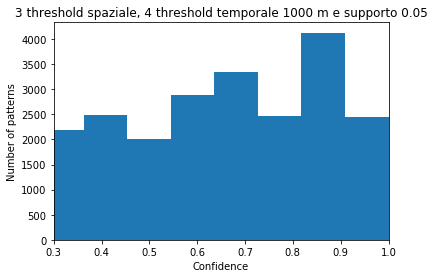

In [207]:
plt.hist(confidence)
plt.xlabel('Confidence')
plt.ylabel('Number of patterns')
plt.title(f'{maxDelta} threshold spaziale, {window_size} threshold temporale {th*1000} m e supporto {support}')
plt.xlim(0.3,1)
plt.savefig(img_support)
plt.show()

In [217]:
print('FILTER PATTERNS WITH AT LEAST 1 T0, DELTA S=0 AND AT LEAST 1 PATTERN WITH AT LEAST 1 PATTERN WITH DELTA S DIFFERENT FROM 0 AND DELTA T DIFFERENT FROM 0')

FILTER PATTERNS WITH AT LEAST 1 T0, DELTA S=0 AND AT LEAST 1 PATTERN WITH AT LEAST 1 PATTERN WITH DELTA S DIFFERENT FROM 0 AND DELTA T DIFFERENT FROM 0


In [218]:
list_influenze=[]
for el in voc_supports.keys():
    delta_spaziale=False
    if ('-' in el):
        all_windows_list=el.split('-')
        if ('T0_0' in all_windows_list[0] ):
            for cons_window in all_windows_list[1::]:
                if ',' in cons_window:
                    for item in cons_window.split(','):                       
                        act_delta=int(item.split('_')[2])
                        if act_delta!=0:
                            delta_spaziale=True
    if delta_spaziale==True:        
        key_list=[]            
        for e in el.split('-'):
            key_list.append([e])
        list_influenze.append([[key_list], [voc_supports[el]]])

In [219]:
# output_file3='results_..._diff_delta_ordered_by_confidence.txt'
file3 = open(output_file3, "w")

In [220]:
lung_different_time_space=0
if len(list_influenze)!=0:
    df_supports=sc.parallelize(list_influenze).toDF().withColumnRenamed('_1','sequence')
    df_supports=df_supports.withColumnRenamed('_2','confidence-freq')
    lung_different_time_space=df_supports.count() 
    #df_supports.show(lung_different_time_space,False)
    #print(lung_different_time_space)

In [233]:
len(list_influenze)

15289

In [221]:
file3.write('Pattern, Confidence-Frequence'+'\n')
file3.write(f'Total number of input patterns: {len(list_influenze)}'+'\n')
if len(list_influenze)!=0:
    for el in list_influenze:       
        file3.write(str(el)+'\n')
file3.close()

In [222]:
# output_file6='results_..._diff_delta_ordered_by_support.txt'
file6 = open(output_file6, "w")

In [223]:
#order list first by support and then by confidence
list_influenze_ordered_by_support = sorted(list_influenze,
                                           key=lambda v: (int(v[1][0].split(" - ")[1]), float(v[1][0].split(" - ")[0])),
                                           reverse=True)

In [224]:
file6.write('Pattern, Confidence-Frequence'+'\n')
file6.write(f'Total number of input patterns: {len(list_influenze_ordered_by_support)}'+'\n')
if len(list_influenze_ordered_by_support)!=0:
    for el in list_influenze_ordered_by_support:       
        file6.write(str(el)+'\n')
file6.close()

In [225]:
print(f'The number of patterns in the pre-filter is: {len_prefix}')

The number of patterns in the pre-filter is: 172188


In [226]:
print(f'The number of items after the filter with at least 2 windows and at least a T0 and delta 0 is: {len(voc_supports)}')

The number of items after the filter with at least 2 windows and at least a T0 and delta 0 is: 24100


In [227]:
# print('STATISTICS about sequences with at least 2 windows_T0_delta0')
# print(f'The average number of windows is: {avg_window}')
# print(f'The minimum number of windows is: {min_window}')
# print(f'The maximum number of windows is: {max_window}')
# print(f'The average number of items is: {avg_items}')
# print(f'The minimum number of items is: {min_items}')
# print(f'The maximum number of items is: {max_items}')

In [228]:
# print(f'The number of patterns in which there is at least one item that repeats within a window is: {repeated_el_window} ')

In [229]:
# print(f'The number of patterns with at least 1 event QuasiVuota and 1 event Vuota is: {lung_vuota_quasi_vuota}')

In [230]:
#  print(f'The number of patterns with at least 1 T0, DELTA S=0 and at least 1 pattern with at least 1 pattern with DELTA S different from 0 and DELTA T different from 0 is: {lung_different_time_space}')

In [231]:
end = time.time()
print(f'The time of execution is: {end-start} s')

The time of execution is: 32584.27987217903 s
